In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from numpy.random import default_rng
import seaborn as sns
import pandas as pd
import itertools

# Notebook 7

## Digital health and computational epidemiology
Author: Michele Tizzoni

---

# Behavior-disease modeling 

In this notebook we implement one of the models described in the study [Towards a Characterization of Behavior-Disease Models](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0023084).


In [8]:
N = int(1e6)
N_sims = 1000
t_max = 1000
I0 = 1

#epidemic parameters
b    = 0.2
mu   = 0.1

#fear parameters
r_b  = 0.05
b_f  = 0.7
mu_f = 0.015

frac = 0.001 #only keep runs where the disease reaches more than this fraction of the population

init = {"S"   : N-I0,
        "S_f" : 0,
        "I"   : I0,
        "R"   : 0,
       }

step = 10 # for making x-axis less clobbered in plots
fontsize = 16

rng = default_rng()

In [2]:
def simulate(init, t_max):

    compartments = {"S"  : init["S"],
                    "S_f": init["S_f"],
                    "I"  : init["I"],
                    "R"  : init["R"],
                   }
    
    time_series = {"S"  : [init["S"]],
                   "S_f": [init["S_f"]],
                   "I"  : [init["I"]],
                   "R"  : [init["R"]],
                   }

    for t in range(0, t_max):
        
        S, S_f, I, R = list(compartments.values())

        ##### TRANSMISSION PROCESSES #####
        # The convention is dABC for a process A + B -> C + B

        # Disease Transmission for S compartment #
        # S + I -(b)-> I + I
        dSII = rng.binomial(S, b*I/N)

        # Disease Transmission for S_f compartment #
        # S_f + I -(r_b*b)-> I + I
        dS_fII = rng.binomial(S_f, r_b*b*I/N)

        # Fear Transmission #
        # S + I -(b_f)-> S_f + I
        dSIS_f = rng.binomial(S, b_f*I/N)

        # Overcoming the fear after contact with R #
        # S_f + R -(mu_f)-> S + R
        dS_fRS = rng.binomial(S_f, mu_f*R/N)

        # Overcoming the fear after contact with S #
        # S_f + S -(mu_f)-> S + S
        dS_fSS = rng.binomial(S_f, mu_f*S/N)

        ##### TRANSITION PROCESSES #####

        # Healing #
        # I -(mu)-> R
        dIR = rng.binomial(I, mu)

        ##################################################################
        #                     # dSII# dS_fII# dSIS_f# dS_fRS# dS_fSS# dIR#
        #                     #     #       #       #       #       #    #
        ##################################################################    
        compartments["S"]   += -dSII         -dSIS_f +dS_fRS +dS_fSS     #
        #                     #     #       #       #       #       #    #
        #######################     #       #       #       #       #    #
        compartments["S_f"] +=       -dS_fII +dSIS_f -dS_fRS -dS_fSS     #
        #                     #     #       #       #       #       #    #
        #######################     #       #       #       #       #    #
        compartments["I"]   += +dSII +dS_fII                         -dIR#
        #                     #     #       #       #       #       #    #
        #######################     #       #       #       #       #    #
        compartments["R"]   +=                                       +dIR#
        #                     #     #       #       #       #       #    #
        ##################################################################

        for key in compartments:
            compartments[key] = np.clip(compartments[key], 0, N)
            time_series[key].append(compartments[key])

        tt = np.linspace(0, t_max, t_max+1)
        
    return tt, time_series

In [9]:
s_matrix   = np.zeros((N_sims, t_max+1))
s_f_matrix = np.zeros((N_sims, t_max+1))
i_matrix   = np.zeros((N_sims, t_max+1))
r_matrix   = np.zeros((N_sims, t_max+1))

for i, (row_s, row_s_f, row_i, row_r) in enumerate(zip(s_matrix, s_f_matrix, i_matrix, r_matrix)):
    print("{}/{}".format(i+1, len(i_matrix)), end='\r')
    tt, result = simulate(init, t_max)
    
    if(result["R"][-1] >= frac * N): # Only keep runs where the desease reaches a significant fraction of the pupulation
        row_s[:]   = [elem*100/N for elem in result["S"]]
        row_s_f[:] = [elem*100/N for elem in result["S_f"]]
        row_i[:]   = [elem*100/N for elem in result["I"]]
        row_r[:]   = [elem*100/N for elem in result["R"]]

# remove rows that only contain 0
# those coorespond to runs below the threshold
s_matrix = s_matrix[~np.all(s_matrix == 0, axis=1)]
s_f_matrix = s_f_matrix[~np.all(s_f_matrix == 0, axis=1)]
i_matrix = i_matrix[~np.all(i_matrix == 0, axis=1)]
r_matrix = r_matrix[~np.all(r_matrix == 0, axis=1)]

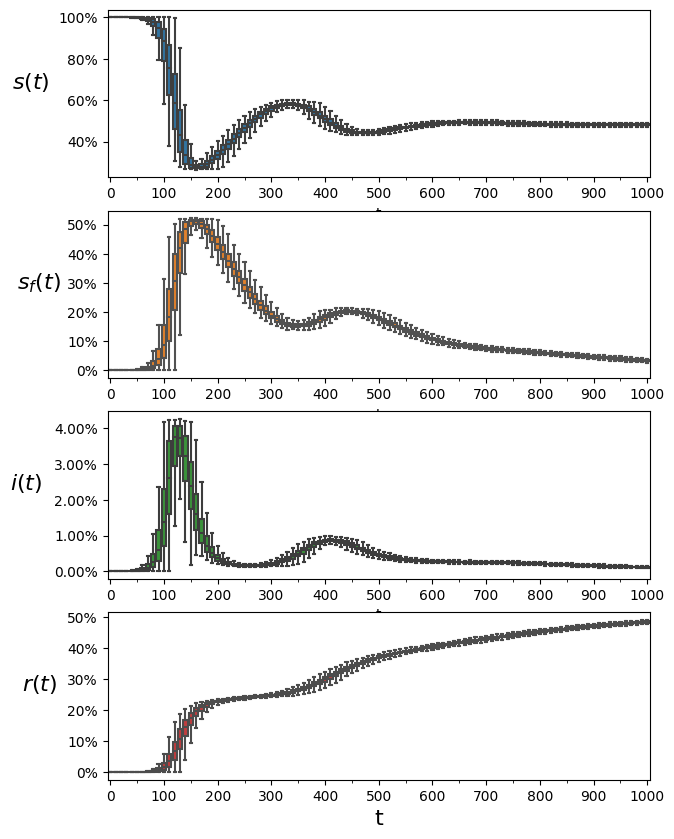

In [10]:
# Visualization

tt = np.linspace(0, t_max, t_max+1)
tt_step = np.array([int(t) for t in tt[::step]])

df_dict = {'t':[],
           's':   [],
           's_f': [],
           'i':   [],
           'r':   [],}

for t in tt_step:
    for (row_s, row_s_f, row_i, row_r) in zip(s_matrix, s_f_matrix, i_matrix, r_matrix):
        df_dict['t'].append(t)
        df_dict['s'].append(row_s[t])
        df_dict['s_f'].append(row_s_f[t])
        df_dict['i'].append(row_i[t])
        df_dict['r'].append(row_r[t])


df = pd.DataFrame(df_dict)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(7, 10))

ax4.set_xlabel('$time[days]$', fontsize = fontsize)

boxplot = sns.boxplot(x='t', y='s',   data=df, color="C0", ax=ax1, showfliers = False)
boxplot = sns.boxplot(x='t', y='s_f', data=df, color="C1", ax=ax2, showfliers = False)
boxplot = sns.boxplot(x='t', y='i',   data=df, color="C2", ax=ax3, showfliers = False)
boxplot = sns.boxplot(x='t', y='r',   data=df, color="C3", ax=ax4, showfliers = False)

for ax in (ax1, ax2, ax3, ax4):
    ax.yaxis.set_major_formatter(mtick.PercentFormatter()) #display "%" sign on y axis
    
    ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mtick.MultipleLocator(5))
    
ax1.set_ylabel('$s(t)$', fontsize = fontsize, labelpad = 20).set_rotation(0)
ax2.set_ylabel('$s_f(t)$', fontsize = fontsize, labelpad = 20).set_rotation(0)
ax3.set_ylabel('$i(t)$', fontsize = fontsize, labelpad = 20).set_rotation(0)
ax4.set_ylabel('$r(t)$', fontsize = fontsize, labelpad = 20).set_rotation(0)

plt.show()